# Baseline
#### Convert histone mark signals and use deep CNN for training.

#### NOTE: Need to activate genomelake environment before this code. Simply type 'genomelake' in terminal.

In [1]:
import os, sys
sys.path.append("..")
import random
# custom file path package
from data import Data_Directories
# custom utility package
from utils.compute_util import *
# package for genomic data
from pybedtools import Interval, BedTool
from genomelake.extractors import ArrayExtractor, BigwigExtractor
# package for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats.stats import pearsonr,spearmanr

Using TensorFlow backend.


In [2]:
window_size = 2001
process_all = False
sample_num = 1000

In [3]:
# retrieve data
data = Data_Directories()
print data.intervals.keys()
print data.input_atac['day0'].keys()
print data.output_histone['day0'].keys()

['day6', 'day3', 'day0']
['100', '140']
['H3K27me3', 'H3K4me1', 'H3K27ac']


In [4]:
# get intervals for day0 data
day0_intervals = list(BedTool(data.intervals['day0']))
print '# of Intervals Extracted for day0: {}'.format(len(day0_intervals))

# get intervals for day3 data
day3_intervals = list(BedTool(data.intervals['day3']))
print '# of Intervals Extracted for day3: {}'.format(len(day3_intervals))

# of Intervals Extracted for day0: 267226
# of Intervals Extracted for day3: 233846


In [5]:
# create an ArrayExtractor for ATAC-seq for day0 with 140 base pairs
bw_140bp_day0 = ArrayExtractor(data.input_atac['day0']['140'])
print 'Finished extracting bigwig for day0, 140bp'

# create an ArrayExtractor for ATAC-seq for day3 with 140 base pairs
bw_140bp_day3 = ArrayExtractor(data.input_atac['day3']['140'])
print 'Finished extracting bigwig for day3, 140bp'

Finished extracting bigwig for day0, 140bp
Finished extracting bigwig for day3, 140bp


In [6]:
# create a BigWigExtractor for histone makr 'H3K27ac' for day0
bw_histone_mark_day0 = BigwigExtractor(data.output_histone['day0']['H3K27ac'])
print 'Finished extracting bigwig for day0, 140bp'

# create a BigWigExtractor for histone makr 'H3K27ac' for day3
bw_histone_mark_day3 = BigwigExtractor(data.output_histone['day3']['H3K27ac'])
print 'Finished extracting bigwig for day3, 140bp'

Finished extracting bigwig for day0, 140bp
Finished extracting bigwig for day3, 140bp


In [7]:
# normalize day0 intervals
normalized_day0_intervals = [normalize_interval(interval, window_size) for interval in day0_intervals if normalize_interval(interval, window_size)]
print 'Finished normalizing day0 intervals!'

# normalize day3 intervals
normalized_day3_intervals = [normalize_interval(interval, window_size) for interval in day3_intervals if normalize_interval(interval, window_size)]
print 'Finished normalizing day3 intervals!'

Finished normalizing day0 intervals!
Finished normalizing day3 intervals!


In [8]:
assert (len(day0_intervals)==len(normalized_day0_intervals))
assert (len(day3_intervals)==len(normalized_day3_intervals))
print "Examples of original intervals"
print [(int(_interval.start)+int(_interval[-1]), [int(_interval.start), int(_interval.end)])
       for _interval in day0_intervals[:3]]
print "Examples of normalized intervals with window size of {}".format(window_size)
print [([int(_interval.start), int(_interval.end)])
       for _interval in  normalized_day0_intervals[:3]]

Examples of original intervals
[(123412027, [123411855, 123412989]), (123411941, [123411855, 123412989]), (131908564, [131908487, 131910071])]
Examples of normalized intervals with window size of 2001
[[123411027, 123413028], [123410941, 123412942], [131907564, 131909565]]


In [9]:
atac_seq_day0 = bw_140bp_day0(normalized_day0_intervals)
atac_seq_day3 = bw_140bp_day3(normalized_day3_intervals)
print atac_seq_day0.shape, atac_seq_day3.shape

(267226, 2001, 5) (233846, 2001, 5)


In [10]:
#TODO: put this into utils if possible
def prune_invalid_intervals(intervals, bigwig_file):
    for _interval in intervals[:]:
        try:
            bigwig_file([_interval])
        except:
            intervals.remove(_interval)
            pass
        
print "Before pruning day0: {}".format(len(normalized_day0_intervals))
prune_invalid_intervals(normalized_day0_intervals, bw_140bp_day0)
print "After pruning day0: {}".format(len(normalized_day0_intervals))

print "Before pruning day3: {}".format(len(normalized_day3_intervals))
prune_invalid_intervals(normalized_day3_intervals, bw_140bp_day3)
print "After pruning day3: {}".format(len(normalized_day3_intervals))

Before pruning day0: 267226
After pruning day0: 267226
Before pruning day3: 233846
After pruning day3: 233846


In [11]:
print "Dimension of ATAC-seq signal: {}".format(bw_140bp_day0(normalized_day0_intervals[:1]).shape)

Dimension of ATAC-seq signal: (1, 2001, 5)


In [12]:
print "Dimension of histone mark signal: {}".format(bw_histone_mark_day0(normalized_day0_intervals[:1]).shape)

Dimension of histone mark signal: (1, 2001)


In [13]:
# replace nan values with zeros and convert it to p-values
histone_mark_day0 = np.nan_to_num(bw_histone_mark_day0(normalized_day0_intervals))
print histone_mark_day0.shape

histone_mark_day3 = np.nan_to_num(bw_histone_mark_day3(normalized_day3_intervals))
print histone_mark_day3.shape

(267226, 2001)
(233846, 2001)


In [14]:
histone_mark_day0 = np.expand_dims(histone_mark_day0, axis=2)
histone_mark_day3 = np.expand_dims(histone_mark_day3, axis=2)
print histone_mark_day0.shape, histone_mark_day3.shape

(267226, 2001, 1) (233846, 2001, 1)


In [15]:
print "Example histone mark signal"
print "\tRaw value: {}".format(bw_histone_mark_day0(normalized_day0_intervals[:1])[0][:5].reshape(-1))

Example histone mark signal
	Raw value: [ 0.01014  0.01014  0.01014  0.02435  0.02435]


In [16]:
from keras.layers import Input, Dense, Conv1D, Dropout
from keras.models import Model
from keras import optimizers
from keras import metrics
from keras import backend as K
from keras.callbacks import Callback, TensorBoard, ReduceLROnPlateau

In [17]:
dropout_rate = 0.5
# parameters for first conv layer
hidden_filters_1 = 20
hidden_kernel_size_1 = 30
# parameters for second conv layer
hidden_filters_2 = 10
hidden_kernel_size_2 = 20
# parameters for the output layer
output_filters = 1
output_kernel_size = 5
# parameters for training
batch_size = 64
num_epochs = 1000
evaluation_freq = 50

In [18]:
'''
Baseline CNN (based on KERAS functional API)
'''
# 
inputs = Input(shape=(window_size, 5, ))
x = Conv1D(
    filters=hidden_filters_1,
    kernel_size=hidden_kernel_size_1,
    padding='same',
    activation='relu',
    strides=1)(inputs)
x = Dropout(dropout_rate)(x)

x = Conv1D(
    filters=hidden_filters_1,
    kernel_size=hidden_kernel_size_1,
    padding='same',
    activation='relu',
    strides=1)(x)
x = Dropout(dropout_rate)(x)

x = Conv1D(
    filters=hidden_filters_1,
    kernel_size=hidden_kernel_size_1,
    padding='same',
    activation='relu',
    strides=1)(x)
x = Dropout(dropout_rate)(x)

x = Conv1D(
    filters=hidden_filters_1,
    kernel_size=hidden_kernel_size_1,
    padding='same',
    activation='relu',
    strides=1)(x)
x = Dropout(dropout_rate)(x)

x = Conv1D(
    filters=hidden_filters_1,
    kernel_size=hidden_kernel_size_1,
    padding='same',
    activation='relu',
    strides=1)(x)
x = Dropout(dropout_rate)(x)

x = Conv1D(
    filters=hidden_filters_1,
    kernel_size=hidden_kernel_size_1,
    padding='same',
    activation='relu',
    strides=1)(x)
x = Dropout(dropout_rate)(x)
x = Conv1D(
    filters=hidden_filters_1,
    kernel_size=hidden_kernel_size_1,
    padding='same',
    activation='relu',
    strides=1)(x)
x = Dropout(dropout_rate)(x)

x = Conv1D(
    filters=hidden_filters_1,
    kernel_size=hidden_kernel_size_1,
    padding='same',
    activation='relu',
    strides=1)(x)
x = Dropout(dropout_rate)(x)

x = Conv1D(
    filters=hidden_filters_1,
    kernel_size=hidden_kernel_size_1,
    padding='same',
    activation='relu',
    strides=1)(x)
x = Dropout(dropout_rate)(x)

x = Conv1D(
    filters=hidden_filters_1,
    kernel_size=hidden_kernel_size_1,
    padding='same',
    activation='relu',
    strides=1)(x)
x = Dropout(dropout_rate)(x)

x = Conv1D(
    filters=hidden_filters_1,
    kernel_size=hidden_kernel_size_1,
    padding='same',
    activation='relu',
    strides=1)(x)
x = Dropout(dropout_rate)(x)


x = Conv1D(
    filters=hidden_filters_2,
    kernel_size=hidden_kernel_size_2,
    padding='same',
    activation='relu',
    strides=1)(x)
x = Dropout(dropout_rate)(x)
x = Conv1D(
    filters=hidden_filters_2,
    kernel_size=hidden_kernel_size_2,
    padding='same',
    activation='relu',
    strides=1)(x)
x = Dropout(dropout_rate)(x)
x = Conv1D(
    filters=hidden_filters_2,
    kernel_size=hidden_kernel_size_2,
    padding='same',
    activation='relu',
    strides=1)(x)
x = Dropout(dropout_rate)(x)
x = Conv1D(
    filters=hidden_filters_2,
    kernel_size=hidden_kernel_size_2,
    padding='same',
    activation='relu',
    strides=1)(x)
x = Dropout(dropout_rate)(x)
x = Conv1D(
    filters=hidden_filters_2,
    kernel_size=hidden_kernel_size_2,
    padding='same',
    activation='relu',
    strides=1)(x)
x = Dropout(dropout_rate)(x)
x = Conv1D(
    filters=hidden_filters_2,
    kernel_size=hidden_kernel_size_2,
    padding='same',
    activation='relu',
    strides=1)(x)
x = Dropout(dropout_rate)(x)

outputs = Conv1D(
    filters=output_filters,
    kernel_size=output_kernel_size,
    padding='same',
    activation='linear',
    strides=1
    )(x)

model = Model(inputs=inputs, outputs=outputs)

In [19]:
def pearson(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(np.multiply(xm,ym))
    r_den = K.sqrt(np.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return K.square(r)

In [20]:
def pearson_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(np.multiply(xm,ym))
    r_den = K.sqrt(np.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - K.square(r)

In [21]:
import tensorflow as tf
# setting optimizer
# adam = optimizers.Adam(clipnorm=1.)
adam = optimizers.Adam()

print "Compiling a model with adam optimizer"
model.compile(loss=pearson_loss,
              optimizer=adam,
              metrics=[pearson])

tensorboard = TensorBoard(log_dir="logs/", write_grads=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              min_lr=0.001)

print model.summary()

Compiling a model with adam optimizer
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2001, 5)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2001, 20)          3020      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2001, 20)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2001, 20)          12020     
_________________________________________________________________
dropout_2 (Dropout)          (None, 2001, 20)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2001, 20)          12020     
_________________________________________________________________
dropout_3 (Dropout)          (None, 20

In [22]:
save_freq = evaluation_freq
output_dir = "plots"
model_dir = "models"
pickle_dir = "pickles"
import pickle
# callback function for plotting loss graph for every 500 epochs
class Plot_Train_Loss_Callback(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.pearsons = []
        self.lrs = []
        self.val_losses = []
        self.val_pearsons = []
        self.epochs = 0

    def on_epoch_end(self, batch, logs={}):
        #'loss': 'pearson': 'lr': 'val_loss': 'val_pearson'
        self.losses.append(logs['loss'])
        self.pearsons.append(logs['pearson'])
        self.lrs.append(logs['lr'])
        self.val_losses.append(logs['val_loss'])
        self.val_pearsons.append(logs['val_pearson'])
        self.epochs += 1
        if self.epochs % save_freq == 0:
            self.model.save(os.path.join(model_dir, 'model_'+str(self.epochs)+".h5"))
            pickle.dump(self.losses, open(os.path.join(pickle_dir, 'loss_'+str(self.epochs)+".p"), 'wb'))
            pickle.dump(self.pearsons, open(os.path.join(pickle_dir, 'pearson_'+str(self.epochs)+".p"), 'wb'))
            pickle.dump(self.lrs, open(os.path.join(pickle_dir, 'lr_'+str(self.epochs)+".p"), 'wb'))
            pickle.dump(self.val_losses, open(os.path.join(pickle_dir, 'val_loss_'+str(self.epochs)+".p"), 'wb'))
            pickle.dump(self.val_pearsons, open(os.path.join(pickle_dir, 'val_pearson_'+str(self.epochs)+".p"), 'wb'))
            # summarize history for loss
#             plt.plot(range(self.epochs), self.losses)
#             plt.title('model loss')
#             plt.ylabel('loss')
#             plt.xlabel('epoch')
#             plt.savefig(os.path.join(output_dir, 'model_train_'+str(self.epochs)+'.png'))
#             plt.close()
    
class Compute_Pearson_Callback(Callback):
    def __init__(self, x_train, y_train):
        self.x_train, self.y_train = x_train, y_train

    def on_train_begin(self, logs={}):
        self.p_train_history = []
        self.epochs = 0

    def on_epoch_end(self, batch, logs={}):
        self.epochs += 1
        x_train, y_train = self.x_train, self.y_train
        y_pred_train = self.model.predict(x_train)
        p_train_list = []
        for y_t, y_pt in zip(y_train, y_pred_train):
            p_train_list.append(pearsonr(y_t.squeeze(), y_pt.squeeze()))
        p_train = np.mean(p_train_list)
        print "Train Pearson Corr: {}".format(p_train)
        self.p_train_history.append(p_train)
        if self.epochs % save_freq == 0:
            # record pearson correlation for train
            plt.plot(range(self.epochs), self.p_train_history)
            plt.title('Pearson Correlation - Train')
            plt.ylabel('pearson correlation')
            plt.xlabel('epoch')
            plt.savefig(os.path.join(output_dir, 'Pearson', 'train_'+str(self.epochs)+'.png'))
            plt.close()

In [23]:
%env CUDA_VISIBLE_DEVICES=4,7
print "Fitting the model..."
test_spearmans = []
test_losses = []
test_pearsons = []
for i in range(num_epochs/evaluation_freq):
    model.fit(atac_seq_day0[:10000],
              histone_mark_day0[:10000],
              batch_size=batch_size,
              epochs=evaluation_freq,
              validation_split=0.25,   
              #shuffle=True,
              callbacks=[tensorboard,
                         reduce_lr,
                         Plot_Train_Loss_Callback()])
    
    # evaluate the model
    scores = model.evaluate(atac_seq_day0[10000:11000], histone_mark_day0[10000:11000])
    print zip(model.metrics_names, scores)
    test_losses.append(scores[0])
    test_pearsons.append(scores[1])
    test_prediction = model.predict(atac_seq_day0[10000:11000])
    test_spearman_sum = 0.0
    for idx, _pred in enumerate(test_prediction):
        rho, _ = spearmanr(histone_mark_day0[10000+idx], _pred)
        test_spearman_sum += rho
    print "Test spearman: {}".format(test_spearman_sum * 1.0 / 1000)
    test_spearmans.append(test_spearman_sum * 1.0 / 1000)

env: CUDA_VISIBLE_DEVICES=4,7
Fitting the model...
Train on 7500 samples, validate on 2500 samples
Epoch 1/50
7500/7500 [==============================] - 15s 2ms/step - loss: 0.8805 - pearson: 0.1195 - val_loss: 0.8681 - val_pearson: 0.1319
Epoch 2/50
7500/7500 [==============================] - 14s 2ms/step - loss: 0.8447 - pearson: 0.1553 - val_loss: 0.8530 - val_pearson: 0.1470
Epoch 3/50
7500/7500 [==============================] - 14s 2ms/step - loss: 0.8336 - pearson: 0.1664 - val_loss: 0.8515 - val_pearson: 0.1485
Epoch 4/50
7500/7500 [==============================] - 14s 2ms/step - loss: 0.8283 - pearson: 0.1717 - val_loss: 0.8590 - val_pearson: 0.1410
Epoch 5/50
7500/7500 [==============================] - 14s 2ms/step - loss: 0.8274 - pearson: 0.1726 - val_loss: 0.8496 - val_pearson: 0.1504
Epoch 6/50
7500/7500 [==============================] - 14s 2ms/step - loss: 0.8235 - pearson: 0.1765 - val_loss: 0.8469 - val_pearson: 0.1531
Epoch 7/50
7500/7500 [=====================

Epoch 6/50
7500/7500 [==============================] - 14s 2ms/step - loss: 0.7337 - pearson: 0.2663 - val_loss: 0.8399 - val_pearson: 0.1601
Epoch 7/50
7500/7500 [==============================] - 14s 2ms/step - loss: 0.7253 - pearson: 0.2747 - val_loss: 0.8398 - val_pearson: 0.1602
Epoch 8/50
7500/7500 [==============================] - 14s 2ms/step - loss: 0.7292 - pearson: 0.2708 - val_loss: 0.8443 - val_pearson: 0.1557
Epoch 9/50
7500/7500 [==============================] - 14s 2ms/step - loss: 0.7262 - pearson: 0.2738 - val_loss: 0.8446 - val_pearson: 0.1554
Epoch 10/50
7500/7500 [==============================] - 14s 2ms/step - loss: 0.7257 - pearson: 0.2743 - val_loss: 0.8465 - val_pearson: 0.1535
Epoch 11/50
7500/7500 [==============================] - 14s 2ms/step - loss: 0.7148 - pearson: 0.2852 - val_loss: 0.8508 - val_pearson: 0.1492
Epoch 12/50
7500/7500 [==============================] - 14s 2ms/step - loss: 0.7241 - pearson: 0.2759 - val_loss: 0.8498 - val_pearson: 0.1

KeyboardInterrupt: 

Text(0,0.5,u'Test Spearman Coefficient')

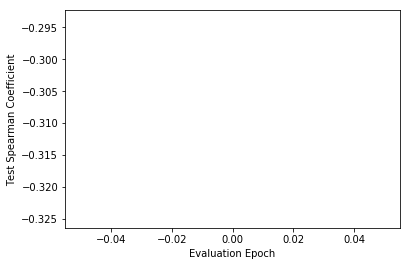

In [24]:
plt.plot(range(len(test_spearmans)), test_spearmans, color='blue')
plt.xlabel('Evaluation Epoch')
plt.ylabel('Test Spearman Coefficient')

Text(0,0.5,u'Test Losses')

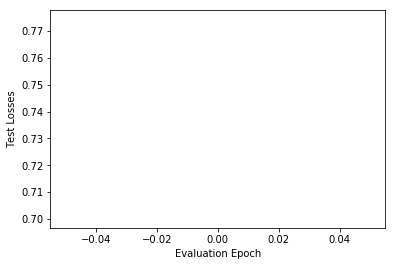

In [25]:
plt.plot(range(len(test_losses)), test_losses, color='blue')
plt.xlabel('Evaluation Epoch')
plt.ylabel('Test Losses')

Text(0,0.5,u'Test Pearsons')

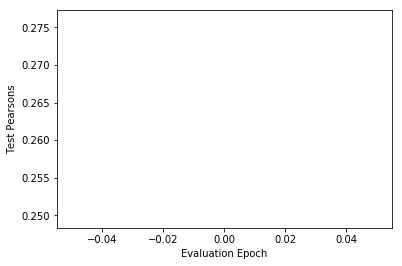

In [26]:
plt.plot(range(len(test_pearsons)), test_pearsons, color='blue')
plt.xlabel('Evaluation Epoch')
plt.ylabel('Test Pearsons')

In [27]:
from itertools import izip
import subprocess
def interval_score_pairs(intervals, scores, merge_type):
    return (izip(intervals, scores) if merge_type is None
            else merged_scores(scores, intervals, merge_type))
def _write_1D_deeplift_track(scores, intervals, file_prefix, merge_type=None,
                             CHROM_SIZES='/mnt/data/annotations/by_release/hg19.GRCh37/hg19.chrom.sizes'):
    assert scores.ndim == 2

    bedgraph = file_prefix + '.bedGraph'
    bigwig = file_prefix + '.bw'

    print 'Writing 1D track of shape: {}'.format(scores.shape)
    print 'Writing to file: {}'.format(bigwig)

    with open(bedgraph, 'w') as fp:
        for interval, score in interval_score_pairs(intervals, scores,
                                                    merge_type):
            chrom = interval.chrom
            start = interval.start
            for score_idx, val in enumerate(score):
                fp.write('%s\t%d\t%d\t%g\n' % (chrom,
                                               start + score_idx,
                                               start + score_idx + 1,
                                               val))
    print 'Wrote bedgraph.'

    try:
        output = subprocess.check_output(
            ['wigToBigWig', bedgraph, CHROM_SIZES, bigwig],
            stderr=subprocess.STDOUT)
        print 'wigToBigWig output: {}'.format(output)
    except subprocess.CalledProcessError as e:
        print 'wigToBigWig terminated with exit code {}'.format(
            e.returncode)
        print 'output was:\n' + e.output

    print 'Wrote bigwig.'

In [28]:
prediction = model.predict(atac_seq_day0[10000:11000]).reshape(1000, 2001)
print prediction.shape
_write_1D_deeplift_track(prediction, normalized_day0_intervals[10000:11000], "bigwig/test")

(1000, 2001)
Writing 1D track of shape: (1000, 2001)
Writing to file: bigwig/test.bw
Wrote bedgraph.
wigToBigWig terminated with exit code 255
output was:
Overlap between chr1 15177248 15177249 and chr1 15177248 15177249.
Please remove overlaps and try again

Wrote bigwig.


In [29]:
prediction = model.predict(atac_seq_day0[0:10000]).reshape(10000, 2001)
print prediction.shape
_write_1D_deeplift_track(prediction, normalized_day0_intervals[0:10000], "bigwig/train")

(10000, 2001)
Writing 1D track of shape: (10000, 2001)
Writing to file: bigwig/train.bw
Wrote bedgraph.
wigToBigWig terminated with exit code 255
output was:
Overlap between chr1 1284150 1284151 and chr1 1284150 1284151.
Please remove overlaps and try again

Wrote bigwig.
